# Is there a difference between male and female brains?
The topic of whether or not there is a typical "male" and "female" brain is hotly contested. Several studies, including [Sex beyond the genitalia: The human brain mosaic](https://www.pnas.org/content/112/50/15468) and [Multivariate revisit to “sex beyond the genitalia”](https://www.pnas.org/content/113/14/E1966) have used a mosaic of various brain features to try and answer this question, with conflicting results.

One of the problems that arise from previous mosaic analysis is that they use the absolute volume of various features of the brain without taking into account that the mean size of a male person's brain is larger than a female person's brain because on average males are larger than females.

In this analysis, we explore if male and female brains can be categorized using volumes of various brain regions expressed as percentages in order to remove the effect of total volume.

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [147]:
# Define figure saving variables.
figsize = (10, 5)
save_name = 'images/{}.png'

## Explore the Data
The NKI_SBA_Volume dataset contains the volumes of various regions of the brain for each participant in the study as well as the total volume of each brain.

In [148]:
df = pd.read_hdf('NKI_SBA_Volume.hdf5', key='NKI')

Create a list of features from the volume variables in the dataset.

In [149]:
features = [name for name in df.columns if name.endswith('volume')]
len(features)

69

In [150]:
df['bio_sex'].value_counts()

1    169
0    103
Name: bio_sex, dtype: int64

Below is the distribution of total brain volumes for all participants.

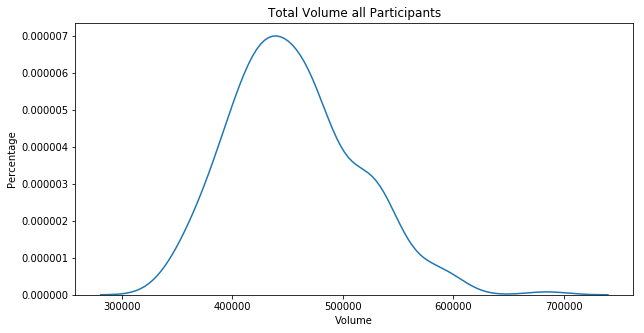

In [151]:
var = 'total_volume'
plt.figure(figsize=figsize)
sns.kdeplot(df[var].values);
plt.title('Total Volume all Participants')
plt.xlabel('Volume')
plt.ylabel('Percentage')
plt.savefig(save_name.format('total_volume_dist'))

Below are the distributions of total brain volumes for male and female subjects. As expected, men have bigger brains. The female brain distribution is less variable than the male distribution.

Male mean: 487165.6116504854	 Female mean: 435993.4082840237
Male std: 56016.24775538615	 Female std: 48148.529005421165


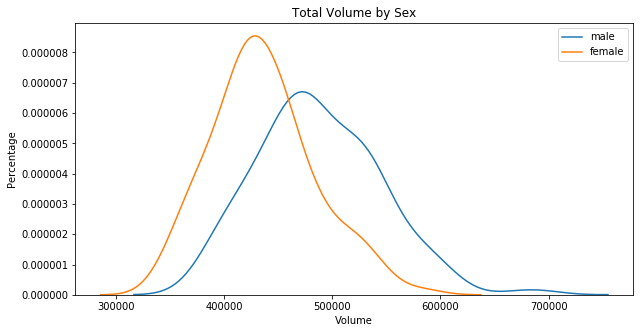

In [152]:
male = df['bio_sex'] == 0
female = df['bio_sex'] == 1

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');
plt.title("Total Volume by Sex")
plt.xlabel('Volume')
plt.ylabel('Percentage')
plt.savefig(save_name.format('total_volume_sex'))

m_mean = df.loc[male, var].mean()
m_std = df.loc[male, var].std()

f_mean = df.loc[female, var].mean()
f_std = df.loc[female, var].std()

print("Male mean: {}\t Female mean: {}\nMale std: {}\t Female std: {}".format(m_mean, f_mean, m_std, f_std))

## Cohen effect size
### Sex

To understand which variables will be the best for predicting male and female brains, we list the variables with the largest cohen effect size between the male and female groups.

In [153]:
def cohen_effect_size(group1, group2):
    """Compute Cohen's effect size (d).

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

In [154]:
def compute_cohen_effect(df, features):
    res = pd.Series()

    grouped = df.groupby('male')
    for var in features:
        groups = grouped[var]
        male = groups.get_group(1)
        female = groups.get_group(0)
        d = cohen_effect_size(male, female)
        res[var] = d
        
    return res

Below are the top features by Cohen effect size. The biggest difference is in total volume, which is expected given the distributions shown above. It is likely that the other top features are strongly correlated with the total volume.

In [155]:
num_features = 12

res = compute_cohen_effect(df, features)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

total_volume                      0.998091
rh_superiorfrontal_volume         0.970546
rh_inferiortemporal_volume        0.964111
rh_lateraloccipital_volume        0.960110
rh_precuneus_volume               0.958064
lh_middletemporal_volume          0.953209
lh_superiorfrontal_volume         0.941572
lh_medialorbitofrontal_volume     0.937211
rh_rostralmiddlefrontal_volume    0.927699
lh_inferiortemporal_volume        0.909025
rh_fusiform_volume                0.890256
rh_lateralorbitofrontal_volume    0.874188
dtype: float64


Below is the distribution of the variable with the second highest cohen effect size. Note the similarity in the shape of the distributions to the shapes of the distributions of the total volumes.

Male mean: 22546.252427184467	 Female mean: 19911.8224852071
Male std: 3165.7150160914352	 Female std: 2397.9989657482133


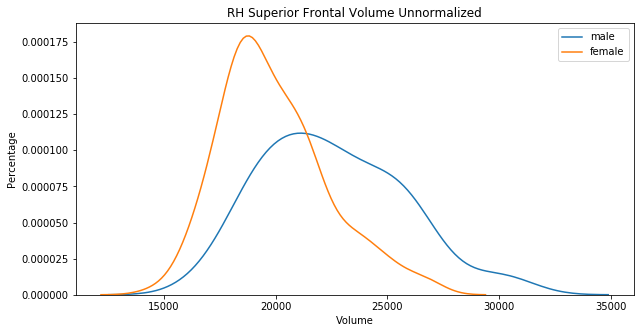

In [156]:
var = 'rh_superiorfrontal_volume'
plt.figure(figsize=figsize)
sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');
plt.title('RH Superior Frontal Volume Unnormalized')
plt.xlabel('Volume')
plt.ylabel('Percentage')
plt.savefig(save_name.format('rh_superior_volume_unnorm'))

m_mean = df.loc[male, var].mean()
m_std = df.loc[male, var].std()

f_mean = df.loc[female, var].mean()
f_std = df.loc[female, var].std()

print("Male mean: {}\t Female mean: {}\nMale std: {}\t Female std: {}".format(m_mean, f_mean, m_std, f_std))

Now, we express the volumes of the brain regions as percentages of the total volume in order to remove the effect of the total brain size.

In [157]:
def divide_by_vol(columns):
    for column in columns:
        df[column + '_norm'] = df[column]/df['total_volume']
        
columns = [name for name in df.columns if name.endswith('volume')]
divide_by_vol(columns)

In [158]:
df.drop('total_volume_norm', axis = 1)
features_norm = [name for name in df.columns if name.endswith('norm')]
len(features)

69

Below are the top features when we normalize for total volume. Note that the effect sizes are less than half of the top effect sizes without normalization. Additionally, the top features are not in the same order, nor are they all the same as the top features without normalization.

In [159]:
num_features = 12

res = compute_cohen_effect(df, features_norm)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
top_by_cohen

/home/ariana/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


lh_middletemporal_volume_norm          0.416500
rh_inferiortemporal_volume_norm        0.378245
lh_rostralmiddlefrontal_volume_norm    0.337220
rh_rostralmiddlefrontal_volume_norm    0.305688
rh_middletemporal_volume_norm          0.300476
lh_inferiortemporal_volume_norm        0.278646
lh_medialorbitofrontal_volume_norm     0.259600
rh_precuneus_volume_norm               0.249023
lh_parsorbitalis_volume_norm           0.234720
lh_supramarginal_volume_norm           0.205109
rh_parsorbitalis_volume_norm           0.189739
rh_inferiorparietal_volume_norm        0.184604
dtype: float64

Below are the distributions of the feature with the highest Cohen effect size for the normalized features. Note that the shapes of the male and female distributions are more similar, and that they have very similar standard deviations.

Male mean: 0.02359251219351494	 Female mean: 0.022660804997766168
Male std: 0.0023213411278019264	 Female std: 0.002183987780623692


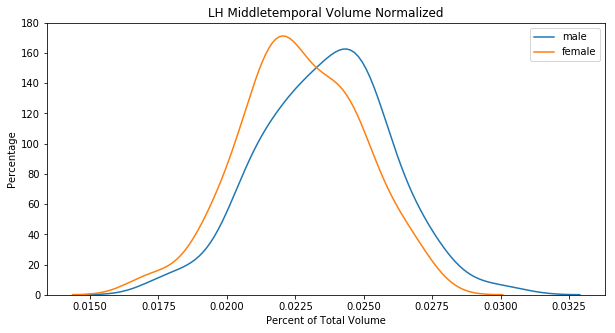

In [160]:
var = 'lh_middletemporal_volume_norm'
plt.figure(figsize=figsize)
sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');
plt.title('LH Middletemporal Volume Normalized')
plt.xlabel('Percent of Total Volume')
plt.ylabel('Percentage')
plt.savefig(save_name.format('lh_middletemporal_volume_norm'))

m_mean = df.loc[male, var].mean()
m_std = df.loc[male, var].std()

f_mean = df.loc[female, var].mean()
f_std = df.loc[female, var].std()

print("Male mean: {}\t Female mean: {}\nMale std: {}\t Female std: {}".format(m_mean, f_mean, m_std, f_std))

Now, we use a logistic regression model using the unnormalized features to categorize male and female brains. Although the model does better than chance, the area under the ROC curve is only 0.72, the R^2 value is 0.67, and the RMSE is 0.57. The RMSE is very high considering that the range of values the model can output are only between 0 and 1. So, this is not a robust model for differentiating male and female brains.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.6829268292682927
Root Mean Squared Error: 0.563092506371473
0.7208848405985686
[[15 14]
 [12 41]]


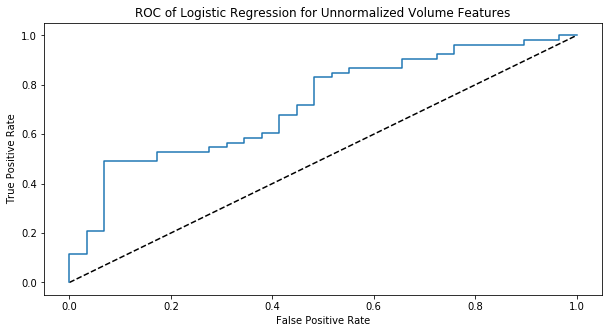

In [161]:
y = df['bio_sex']
X = df.drop(list(set(df.columns).difference(set(features))), axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Unnormalized Volume Features")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig(save_name.format('roc_vol_unnorm'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

Now, we use the normalized features in the logistic regression model to predict if a brain is male or female. Although the area under the ROC is slightly larger, the R^2 value and RMSE are both slightly larger, so this model is also not a robust model for differentiating male and female brains.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.6463414634146342
Root Mean Squared Error: 0.59469196781642
0.7807417046193884
[[ 0 29]
 [ 0 53]]


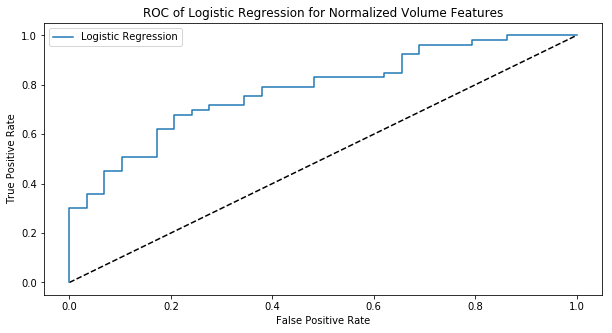

In [162]:
y = df['bio_sex']
X = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Normalized Volume Features")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_norm'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

### Age
We want to see if the volume features can be used to predict the age of a participant. To do this, we split the participants into a "young" group and an "old" group, where the cutoff is the median age.

In [163]:
df['age'].describe()

count    272.000000
mean      45.783088
std       18.861331
min       12.000000
25%       26.000000
50%       49.000000
75%       60.000000
max       85.000000
Name: age, dtype: float64

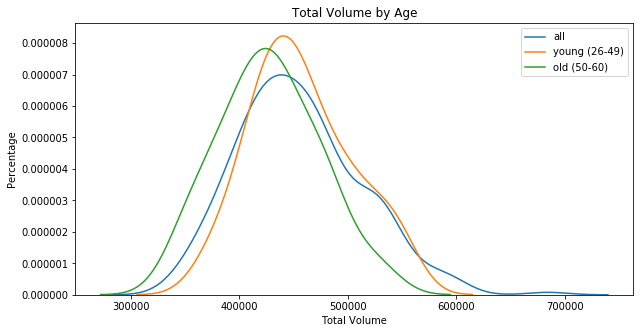

In [164]:
var = 'total_volume'

plt.figure(figsize=figsize)
sns.kdeplot(df[var].values, label='all');

young = (df['age'] <= 49) & (df ['age'] >= 26)
old = (df['age'] > 49) & (df['age'] <= 60)

sns.kdeplot(df.loc[young, var], label='young (26-49)')
sns.kdeplot(df.loc[old, var], label='old (50-60)');
plt.title("Total Volume by Age")
plt.xlabel("Total Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('age_total_vol_dist'))

In [165]:
conditions = [
    (df['age'] <= 49) & (df['age'] >= 26),
    (df['age'] <= 60) & (df['age'] > 49)]
choices = [1, 0]
df['young'] = np.select(conditions, choices, default=np.nan)
df['young'].mean()

0.5704225352112676

In [166]:
def compute_cohen_effect_age(df, features):
    res = pd.Series()

    grouped = df.groupby('young')
    for var in features:
        groups = grouped[var]
        young = groups.get_group(1)
        old = groups.get_group(0)
        d = cohen_effect_size(young, old)
        res[var] = d
        
    return res

In [167]:
num_features = 12

res = compute_cohen_effect_age(df, features)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

rh_medialorbitofrontal_volume     0.761393
lh_parstriangularis_volume        0.740418
lh_lateralorbitofrontal_volume    0.717843
lh_rostralmiddlefrontal_volume    0.712378
rh_posteriorcingulate_volume      0.692557
rh_inferiorparietal_volume        0.680425
rh_parstriangularis_volume        0.661210
rh_parsopercularis_volume         0.661119
rh_superiorfrontal_volume         0.659108
total_volume                      0.650822
lh_middletemporal_volume          0.633724
lh_parsopercularis_volume         0.630243
dtype: float64


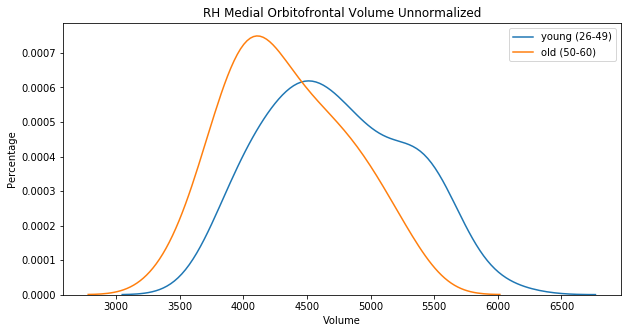

In [168]:
young = df['young'] == 1
old = df['young'] == 0

var = 'rh_medialorbitofrontal_volume'

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[young, var], label='young (26-49)')
sns.kdeplot(df.loc[old, var], label='old (50-60)');
plt.title("RH Medial Orbitofrontal Volume Unnormalized")
plt.xlabel("Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('rh_medialorbitio_unnorm_age'))

In [169]:
num_features = 12

res = compute_cohen_effect_age(df, features_norm)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

lh_rostralmiddlefrontal_volume_norm    0.475797
lh_parstriangularis_volume_norm        0.404769
rh_parsopercularis_volume_norm         0.342945
rh_transversetemporal_volume_norm      0.319506
rh_parstriangularis_volume_norm        0.311488
rh_inferiorparietal_volume_norm        0.301266
lh_middletemporal_volume_norm          0.300623
rh_posteriorcingulate_volume_norm      0.299719
rh_bankssts_volume_norm                0.296518
lh_parsopercularis_volume_norm         0.234782
lh_caudalmiddlefrontal_volume_norm     0.228521
lh_lateralorbitofrontal_volume_norm    0.225363
dtype: float64


/home/ariana/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


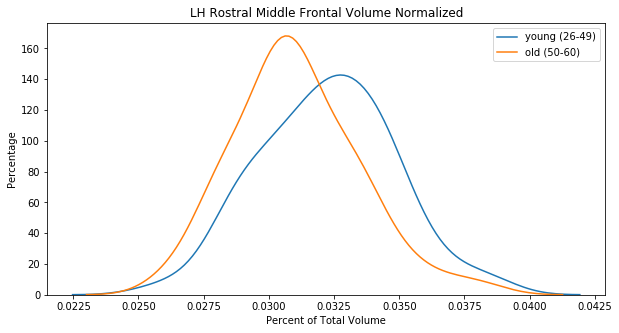

In [170]:
young = df['young'] == 1
old = df['young'] == 0

var = 'lh_rostralmiddlefrontal_volume_norm'

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[young, var], label='young (26-49)')
sns.kdeplot(df.loc[old, var], label='old (50-60)');
plt.title("LH Rostral Middle Frontal Volume Normalized")
plt.xlabel("Percent of Total Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('lh_rostralmiddlefrontal_norm_age'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.5348837209302325
Root Mean Squared Error: 0.6819943394704735
0.5282608695652173
[[ 8 12]
 [ 8 15]]


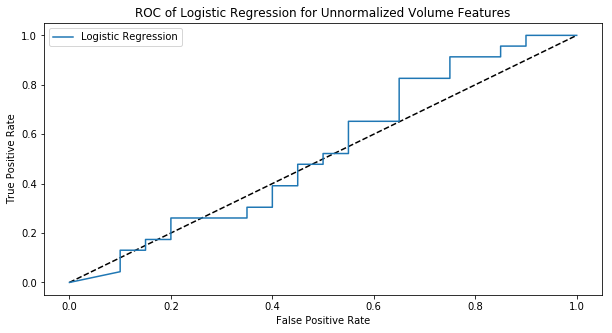

In [171]:
features.append('young')
temp = df.drop(list(set(df.columns).difference(set(features))), axis=1).dropna()
features.pop()


y = temp['young']
X = temp.drop('young', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Unnormalized Volume Features")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_age_unnorm'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.5348837209302325
Root Mean Squared Error: 0.6819943394704735
0.5326086956521738
[[ 0 20]
 [ 0 23]]


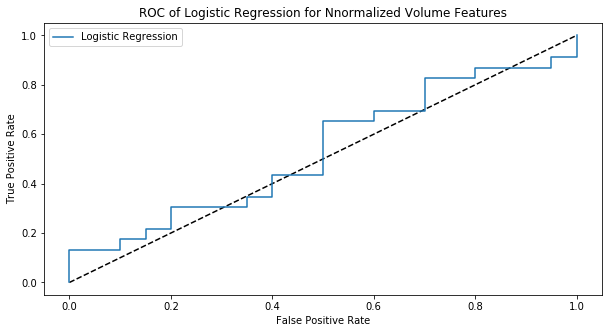

In [172]:
features_norm.append('young')
temp = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1).dropna()
features_norm.pop()


y = temp['young']
X = temp.drop('young', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Nnormalized Volume Features")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_norm_age'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

### All Ages

In [173]:
df['age'].describe()

count    272.000000
mean      45.783088
std       18.861331
min       12.000000
25%       26.000000
50%       49.000000
75%       60.000000
max       85.000000
Name: age, dtype: float64

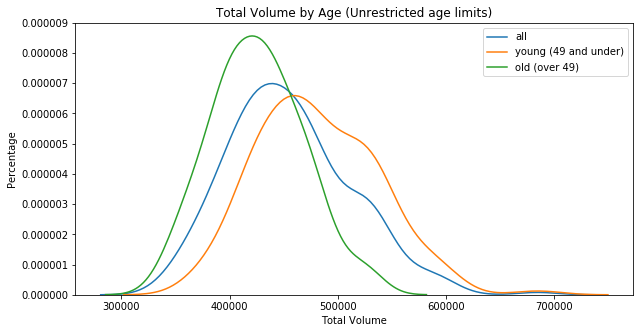

In [174]:
var = 'total_volume'

plt.figure(figsize=figsize)
sns.kdeplot(df[var].values, label='all');

young2 = df['age'] <= 49
old2 = df['age'] > 49

sns.kdeplot(df.loc[young2, var], label='young (49 and under)')
sns.kdeplot(df.loc[old2, var], label='old (over 49)');
plt.title("Total Volume by Age (Unrestricted age limits)")
plt.xlabel("Total Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('age_total_vol_dist_all'))

In [175]:
conditions = [
    (df['age'] <= 49),
    (df['age'] > 49)]
choices = [1, 0]
df['young2'] = np.select(conditions, choices, default=np.nan)
df['young2'].mean()

0.5367647058823529

In [176]:
def compute_cohen_effect_age(df, features):
    res = pd.Series()

    grouped = df.groupby('young2')
    for var in features:
        groups = grouped[var]
        young = groups.get_group(1)
        old = groups.get_group(0)
        d = cohen_effect_size(young, old)
        res[var] = d
        
    return res

In [177]:
num_features = 12

res = compute_cohen_effect_age(df, features)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

print(top_by_cohen)

lh_superiorfrontal_volume         1.192475
lh_lateralorbitofrontal_volume    1.145116
rh_superiorfrontal_volume         1.126841
lh_rostralmiddlefrontal_volume    1.125618
total_volume                      1.116835
rh_bankssts_volume                1.089253
lh_parstriangularis_volume        1.079199
rh_parsopercularis_volume         1.071623
rh_inferiorparietal_volume        1.066946
lh_middletemporal_volume          1.063581
rh_parstriangularis_volume        1.044952
rh_lateralorbitofrontal_volume    1.027525
dtype: float64


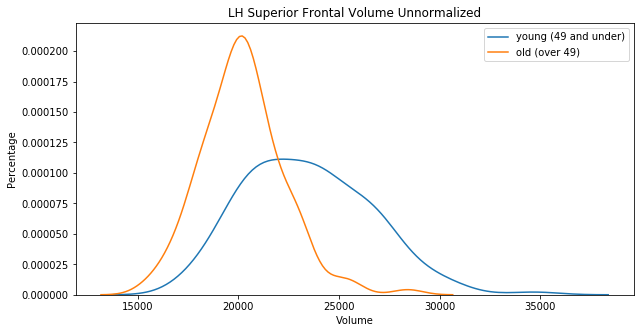

In [178]:
young = df['young2'] == 1
old = df['young2'] == 0

var = 'lh_superiorfrontal_volume'

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[young, var], label='young (49 and under)')
sns.kdeplot(df.loc[old, var], label='old (over 49)');
plt.title("LH Superior Frontal Volume Unnormalized")
plt.xlabel("Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('lh_superiorfrontal_unnorm_age_all'))

In [179]:
num_features = 12

res = compute_cohen_effect_age(df, features_norm)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

lh_rostralmiddlefrontal_volume_norm    0.629192
rh_bankssts_volume_norm                0.493653
rh_parsopercularis_volume_norm         0.466349
lh_middletemporal_volume_norm          0.461419
lh_parstriangularis_volume_norm        0.457526
rh_inferiorparietal_volume_norm        0.400318
rh_middletemporal_volume_norm          0.389172
rh_parstriangularis_volume_norm        0.375779
lh_superiorfrontal_volume_norm         0.374386
rh_parsorbitalis_volume_norm           0.352402
lh_bankssts_volume_norm                0.323629
lh_superiortemporal_volume_norm        0.296492
dtype: float64


/home/ariana/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


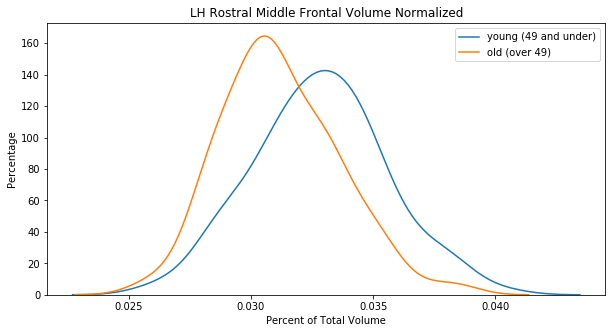

In [180]:
young = df['young2'] == 1
old = df['young2'] == 0

var = 'lh_rostralmiddlefrontal_volume_norm'

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[young, var], label='young (49 and under)')
sns.kdeplot(df.loc[old, var], label='old (over 49)');
plt.title("LH Rostral Middle Frontal Volume Normalized")
plt.xlabel("Percent of Total Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('lh_rostralmiddlefrontal_norm_age_all'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.6951219512195121
Root Mean Squared Error: 0.5521576303742327
0.7454044117647058
[[25  9]
 [16 32]]


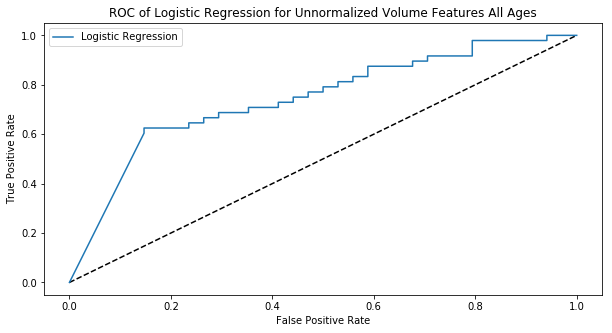

In [182]:
features.append('young2')
temp = df.drop(list(set(df.columns).difference(set(features))), axis=1).dropna()
features.pop()


y = temp['young2']
X = temp.drop('young2', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Unnormalized Volume Features All Ages")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_age_unnorm_all'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.5853658536585366
Root Mean Squared Error: 0.6439209162167846
0.7481617647058824
[[ 0 34]
 [ 0 48]]


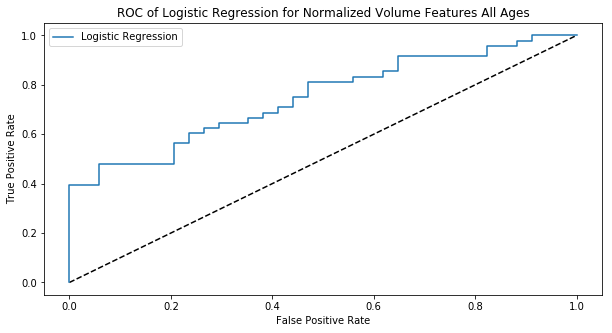

In [183]:
features_norm.append('young2')
temp = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1).dropna()
features_norm.pop()


y = temp['young2']
X = temp.drop('young2', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Normalized Volume Features All Ages")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_age_norm_all'))

                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

## Connectivity

In [184]:
df_1000 = pd.read_excel('brain_mosaic_data/1000_Connectomes_age_18-26_VBM.xlsx')
df_1000.head()

,bio_sex,age,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,...,Cerebelum_00_L,Cerebelum_00_R,Vermis_0_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_00
0,1,18,0.436035,0.406023,0.361779,0.369537,0.495171,0.479090,0.420118,0.444269,...,0.257104,0.247064,0.431084,0.471217,0.572555,0.590969,0.575713,0.558999,0.524192,0.226187
1,1,18,0.422395,0.430086,0.383270,0.390875,0.477471,0.450275,0.448891,0.460303,...,0.245738,0.197609,0.383902,0.421114,0.501804,0.560840,0.566743,0.572814,0.505971,0.202734
2,1,18,0.439540,0.430842,0.385297,0.376834,0.520610,0.472500,0.454426,0.417339,...,0.245801,0.246097,0.418835,0.424117,0.510495,0.597151,0.604129,0.618324,0.606951,0.285061
3,1,18,0.473102,0.449665,0.416976,0.417434,0.536880,0.532697,0.471110,0.502046,...,0.215978,0.202993,0.395247,0.431441,0.524903,0.577355,0.629283,0.642825,0.570416,0.231166
4,1,18,0.382771,0.380443,0.347929,0.359899,0.463163,0.453011,0.393531,0.393259,...,0.236000,0.277785,0.370647,0.434968,0.583758,0.564699,0.543617,0.546831,0.565252,0.247790


In [185]:
df_1000.columns

Index(['bio_sex', 'age', 'Precentral_L', 'Precentral_R', 'Frontal_Sup_L',
       'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R',
       'Frontal_Mid_L', 'Frontal_Mid_R',
       ...
       'Cerebelum_00_L', 'Cerebelum_00_R', 'Vermis_0_2', 'Vermis_3',
       'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9',
       'Vermis_00'],
      dtype='object', length=118)

In [186]:
df_1000['bio_sex'].replace(1, 0, inplace=True)
df_1000['bio_sex'].replace(2, 1, inplace=True)

male = df_1000['bio_sex'] == 0
female = df_1000['bio_sex'] == 1
df_1000['bio_sex'].value_counts()

1    385
0    240
Name: bio_sex, dtype: int64

Distributions of total volume for male and female subjects.  As expected, men have bigger brains.

## Cohen effect size

Let's look for the features that show the biggest difference between men and women.

Here are the top features by Cohen effect size.  The biggest difference is in total volume.  I suspect that the other top candidates are strongly correlated with total volume.

In [187]:
def compute_cohen_effect(df, features):
    res = pd.Series()

    grouped = df.groupby('bio_sex')
    for var in features:
        groups = grouped[var]
        male = groups.get_group(1)
        female = groups.get_group(0)
        d = cohen_effect_size(male, female)
        res[var] = d
        
    return res

In [188]:
num_features = 12
features = list(df_1000.drop(['age', 'bio_sex'], axis=1).columns)

res = compute_cohen_effect(df_1000, features)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

Vermis_7             0.601494
Hippocampus_R        0.576675
Caudate_L            0.537445
Cerebelum_Crus2_R    0.503056
Postcentral_R        0.488203
Hippocampus_L        0.462809
Frontal_Inf_Orb_L    0.456477
Frontal_Sup_Orb_L    0.455499
Cerebelum_Crus2_L    0.449714
Parietal_Inf_R       0.429542
Postcentral_L        0.427087
Frontal_Mid_Orb_L    0.425625
dtype: float64


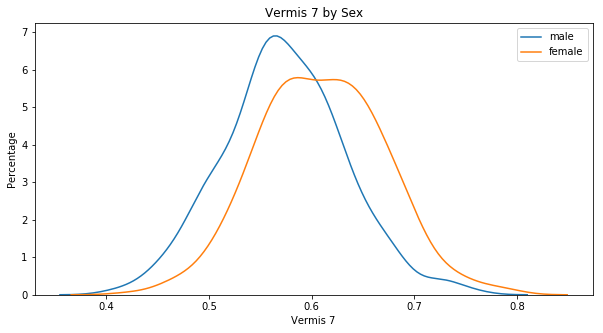

In [189]:
var = 'Vermis_7'
plt.figure(figsize=figsize)
sns.kdeplot(df_1000.loc[male, var], label='male')
sns.kdeplot(df_1000.loc[female, var], label='female');
plt.title("Vermis 7 by Sex")
plt.xlabel('Vermis 7')
plt.ylabel('Percentage')
plt.savefig(save_name.format('verm_sex'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.6276595744680851
Root Mean Squared Error: 0.6101970382851059
0.727038727038727
[[ 15  62]
 [  8 103]]


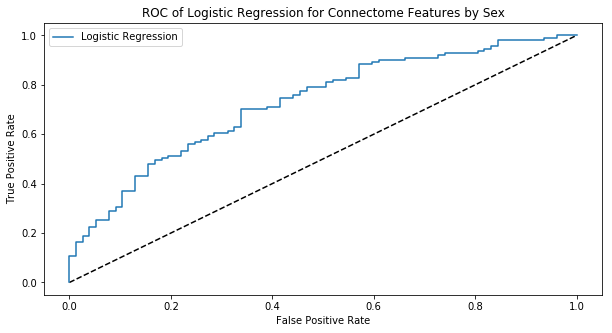

In [191]:
features.append('bio_sex')
temp = df_1000.drop(list(set(df_1000.columns).difference(set(features))), axis=1).dropna()
features.pop()

y = temp['bio_sex']
X = temp.drop('bio_sex', axis=1)

# temp['bio_sex'].value_counts()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Connectome Features by Sex")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_sex_conn'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

In [192]:
df_1000['age'].describe()

count    625.000000
mean      21.516800
std        1.975034
min       18.000000
25%       20.000000
50%       21.000000
75%       23.000000
max       26.000000
Name: age, dtype: float64

In [193]:
conditions = [
    (df_1000['age'] <= 21),
    (df_1000['age'] > 21)]
choices = [1, 0]
df_1000['young'] = np.select(conditions, choices, default=np.nan)
df_1000['young'].mean()

0.5456

In [194]:
def compute_cohen_effect_age(df, features):
    res = pd.Series()

    grouped = df.groupby('young')
    for var in features:
        groups = grouped[var]
        young = groups.get_group(1)
        old = groups.get_group(0)
        d = cohen_effect_size(young, old)
        res[var] = d
        
    return res

In [195]:
num_features = 12

res = compute_cohen_effect_age(df_1000, features)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

Insula_R           0.436826
Precentral_R       0.410753
Insula_L           0.374693
Frontal_Mid_R      0.372729
Temporal_Inf_R     0.359378
Temporal_Mid_R     0.341947
Frontal_Mid_L      0.339900
Parietal_Inf_R     0.336717
Rolandic_Oper_R    0.332593
Fusiform_R         0.326248
Heschl_R           0.323768
Olfactory_R        0.320996
dtype: float64


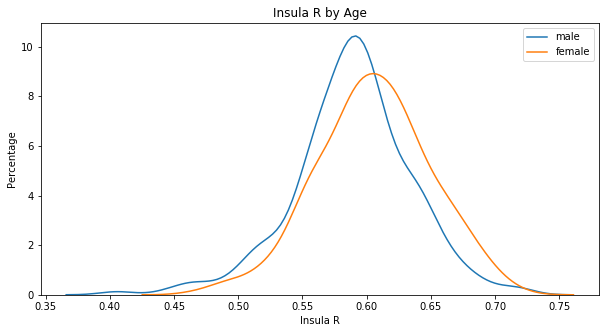

In [197]:
var = 'Insula_R'
plt.figure(figsize=figsize)
sns.kdeplot(df_1000.loc[male, var], label='male')
sns.kdeplot(df_1000.loc[female, var], label='female');
plt.title("Insula R by Age")
plt.xlabel('Insula R')
plt.ylabel('Percentage')
plt.savefig(save_name.format('insula_age'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.5212765957446809
Root Mean Squared Error: 0.6918984060216639
0.5644459706959708
[[26 58]
 [32 72]]


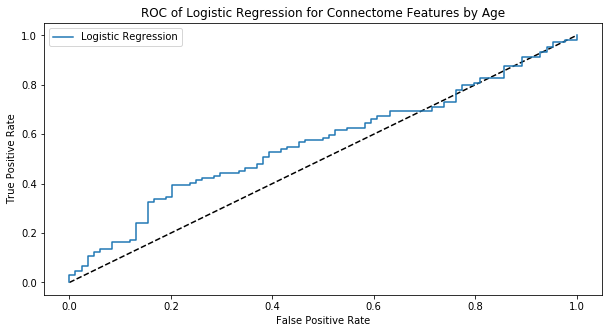

In [198]:
features.append('young')
temp = df_1000.drop(list(set(df_1000.columns).difference(set(features))), axis=1).dropna()
features_norm.pop()

y = temp['young']
X = temp.drop('young', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Connectome Features by Age")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_age_conn'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))